In [1]:
#Se importan las librerias a utlizar en el desarrollo del ejecicio
import pandas as pd
import numpy as np
import random

#Graficos
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn.tree import export_graphviz

#ML
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

Using TensorFlow backend.


* El dataset inscripción corresponde al listado de personas que se inscriben en el programa "Salud Visual" de la Alcaldía de Medellín el cual busca asignar recursos del presupuesto participativo a la atención visual sobre las personas mayores de 18 años
* El dataset atención corresponde al listado de pacientes atendidos en el programa "Salud Visual"
* El dataset síntomas corresponde al análisis del campo descripción del dataset inscripción, las cuales fueron procesadas en Atlas TI para determinar molestias claves en los pacientes

In [2]:
atencion = pd.read_excel('ATENCIONES_D.xlsx',sheet_name='ATENCIONES', skiprows = 1)
inscripcion = pd.read_excel('ATENCIONES_D.xlsx',sheet_name='INSCRITOS')
sintomas = pd.read_excel('Sintomas.xlsx',sheet_name='sintomas')

Integración de bases de datos de atención, inscripción y sintomas

In [4]:
inscritos_sintomas = inscripcion.merge(sintomas, on = ['ID','Ficho_Inscripcion'], how = 'left' )

In [5]:
inscritos_sintomas.shape

(11819, 40)

In [6]:
#Se integran los sintomas al dataset
optometria_raw = atencion.merge(inscritos_sintomas, on = 'ID')

In [7]:
optometria_raw.shape

(8117, 78)

Análisis general de los datos numéricos 

In [17]:
optometria_raw.describe()

,CONSECUTIVO,ID,EDAD,CONSULTA,ESTUCHE Y PAÑO,MONTURA,EJE-OD,2\nLentes monofocales en CR-39 tallados,3\nLentes monofocales en policarbonato terminados\n,5\nLentes bifocales flat top CR-39 terminados,...,Dificultad_para_ver,Dificultad_para_leer_letras_pequeñas,Leer_a_una_distancia_mayor_,Secreciones_(Pus_o_mucosidad),Leer_a_una_distancia_menor_,Ojos_Enrojecidos,Mareos_migraña_y_vomito,Inflamación,Temblor_en_los_ojos,Cestelleos_manchas_flotantes_y_desprendimiento_de_la_retina
count,8117.000000,8.117000e+03,8117.000000,8117.0,7762.0,7762.0,4608.000000,8110.000000,8110.000000,8117.000000,...,7801.00000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000
mean,46936.652088,5.834048e+12,47.991007,1.0,1.0,1.0,68.299588,0.035265,0.108631,0.022668,...,0.04102,0.500449,0.134214,0.259326,0.075375,0.278682,0.023971,0.011409,0.003461,0.000385
std,2799.182229,7.265636e+13,14.596800,0.0,0.0,0.0,51.564736,0.235025,0.443544,0.196014,...,0.19835,0.500032,0.340903,0.438293,0.264012,0.448380,0.152969,0.106208,0.058733,0.019608
min,4545.000000,1.919140e+05,0.000000,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44567.000000,4.268571e+07,39.000000,1.0,1.0,1.0,15.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,47136.000000,4.353945e+07,51.000000,1.0,1.0,1.0,80.000000,0.000000,0.000000,0.000000,...,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,49200.000000,7.173814e+07,57.000000,1.0,1.0,1.0,95.000000,0.000000,0.000000,0.000000,...,0.00000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,61977.000000,9.636632e+14,99.000000,1.0,1.0,1.0,180.000000,2.000000,2.000000,2.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Del análisis preliminar de la información los pacientes atendidos, se depuran las variables que no están categorizadas en función del diagnóstico

Características usadas para generar cobro

* Tipo de lente
* Total lentes unitarios
* Valor_usuario
* Referencia_montura
* Lentes monofocales en CR-39 terminados
* Lentes monofocales en CR-39 tallados
* Lentes monofocales en policarbonato terminados
* Lentes monofocales en policarbonato tallado
* Lentes bifocales flat top CR-39 terminados
* Lentes bifocales flat top CR-39 tallados
* Lentes bifocales flat top policarbonato
* Lentes bifocales invisible CR-39 terminados
* Lentes bifocales invisible CR-39 tallados
* Lentes bifocales invisible policarbonato
* Lentes progresivos en CR-39
* Lentes progresivos en policarbonato

Caraterísticas de identificación
* Consecutivo. Corresponde al id entregado en la atención y no aporta información al modelo
* Ficho de inscripcion
* Direccion Residencia
* Fecha de nacimiento
* Tipo de documento
* Barrio
* Direccion Correspondencia
* Sisben 
* Descripcion

Características de uso administrativo de la Alcaldía de Medellín
* Poblacion
* Etnia. 
* Ocupación. 


El diagnóstico Z010 corresponde a una consulta de optometría que no tuvo un diagnóstico principal

Selección de características a partir del juicio del experto

Estas características son las que quedan luego de retirar las no variables que no están en función del análisis

In [9]:
columnas = ['EDAD','CONSULTA','ESTUCHE Y PAÑO','MONTURA', 'DX\nPPAL\nCIE 10','ESFERA-OD','CILINDRO-OD','EJE-OD','ADD-OD','ESFERA-OI','CILINDRO-OI','EJE-OI','ADD-OI','Genero','Exam_ojos','Usa_Gafas','Tiem_gafas','Glaucoma','Enfermedad','Picazón_irritación_Ardor', 'Ojos_cansados_doloridos', 'Ojos_llorosos', 'Ojos_secos', 'Visión_borrosa', 'Visión_doble', 'Mayor_sensibilidad_a_la_luz',
'Dificultad_para_ver', 'Dificultad_para_leer_letras_pequeñas', 'Leer_a_una_distancia_mayor_', 'Secreciones_(Pus_o_mucosidad)',      'Leer_a_una_distancia_menor_', 'Ojos_Enrojecidos', 'Mareos_migraña_y_vomito', 'Inflamación', 'Temblor_en_los_ojos',       'Cestelleos_manchas_flotantes_y_desprendimiento_de_la_retina','ID']

In [10]:
optometria_dep = optometria_raw[columnas]

Ajuste de forma de encabezado

In [11]:
optometria_dep.rename(columns={'DX\nPPAL\nCIE 10':'Diagnostico'}, inplace = True)
optometria_dep.rename(str.lower, axis='columns', inplace = True)

Depuración y Análisis de los datos

In [12]:
#Se borran los registros duplicados por id en caso de que existan
optometria_dep.drop_duplicates('id', keep = 'last', inplace = True)

In [23]:
optometria_dep.shape

(8117, 37)

In [13]:
#Se eliminan toda aquellas filas que contengan en todos su campos valores nulos
optometria_dep.dropna(how = 'all', inplace = True)

In [25]:
optometria_dep.shape

(8117, 37)

EDAD
La edades oscilan entre los 19 a 81 anios, teniendo unos valores atipicos atipicos por encima de 81 anios y de cero anios.
En la fuente de datos, la edad más frecuente es 59

In [68]:
optometria_dep['edad'].describe()

count    8138.000000
mean       47.986483
std        14.594610
min         0.000000
25%        39.000000
50%        51.000000
75%        57.000000
max        99.000000
Name: edad, dtype: float64

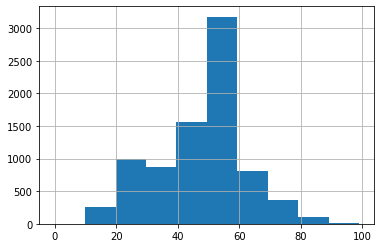

In [69]:
optometria_dep['edad'].hist() 

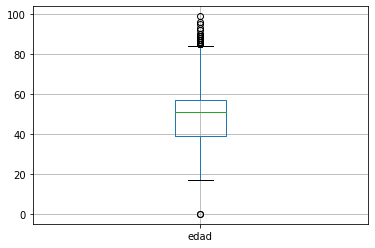

In [70]:
optometria_dep.boxplot('edad')

Se revisan los outliers de edad. El programa "Salud Visual" esta diseniado para mayores de edad, por lo tanto se restringuen los valores del data frame bajo este criterio

In [14]:
optometria_dep.drop(optometria_dep[optometria_dep['edad'] < 18].index, axis = 0, inplace = True)

In [28]:
optometria_dep.shape

(8114, 37)

La columna consulta toma el valor de 1, lo cual quiere decir que fue atendido, dado que hay poca varibilidad se considera candidata a eliminar

In [74]:
optometria_dep['consulta'].describe()

count    8135.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: consulta, dtype: float64

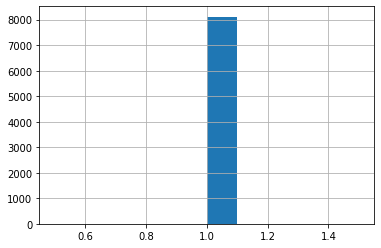

In [15]:
optometria_dep['consulta'].hist() 

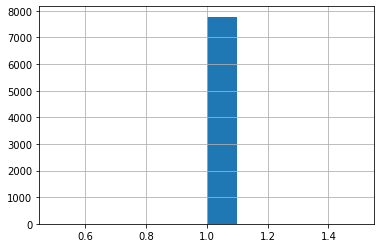

In [76]:
optometria_dep['estuche y paño'].hist()

In [77]:
optometria_dep['estuche y paño'].unique()

array([ 1., nan])

Se completan los valores nulos de algunas características, teniendo en cuenta que los valores de 1 y 0 corresponden a Si y No respectivamente

In [17]:
values_em = {'estuche y paño': 0, 'montura' : 0, 'esfera-od':0, 'cilindro-od':0, 'eje-od':0, 'add-od':0, 'esfera-oi':0,
'cilindro-oi':0, 'eje-oi':0, 'add-oi':0, 'picazón_irritación_ardor':0, 'ojos_cansados_doloridos':0, 'ojos_llorosos':0,
'ojos_secos':0, 'visión_borrosa':0, 'visión_doble':0, 'mayor_sensibilidad_a_la_luz':0, 'dificultad_para_ver':0,
'dificultad_para_leer_letras_pequeñas':0, 'leer_a_una_distancia_mayor_':0, 'secreciones_(pus_o_mucosidad)':0, 
'leer_a_una_distancia_menor_':0, 'ojos_enrojecidos':0, 'mareos_migraña_y_vomito':0, 'inflamación':0,
'temblor_en_los_ojos':0,'cestelleos_manchas_flotantes_y_desprendimiento_de_la_retina':0}

In [18]:
optometria_dep.fillna(value = values_em, inplace = True)

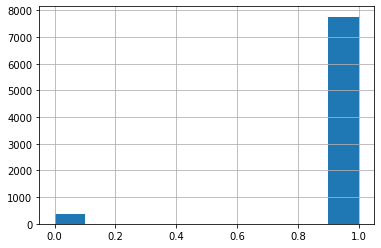

In [36]:
optometria_dep['montura'].hist()

In [133]:
optometria_dep.groupby(['montura'])['montura'].count()

montura
0.0     356
1.0    7779
Name: montura, dtype: int64

In [134]:
optometria_dep.groupby(['estuche y paño'])['estuche y paño'].count()

estuche y paño
0.0     356
1.0    7779
Name: estuche y paño, dtype: int64

In [ ]:
Las variables estuche y paño y montura indican que al paciente le recetaron gafas, por lo tanto se puede agrupar en usa sola dimensión.

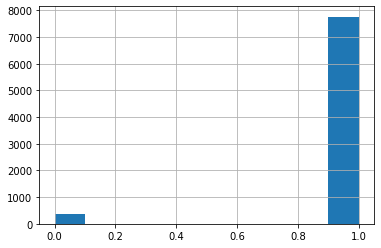

In [19]:
optometria_dep['requiere_gafas'] = np.where((optometria_dep['estuche y paño'] == 1) & (optometria_dep['montura'] == 1),1,0) #1 Tiene gafas, 0 no tiene
optometria_dep['requiere_gafas'].hist()

Los diagnósticos con mayor frecuencia en el estudio realizado en el 2019 son H524 - Presbicia, H522 - Astigmatismo, H521 - Miopía. El diagnostico Z010 significa que el paciente fue diagnosticado sin enfermedad visual.

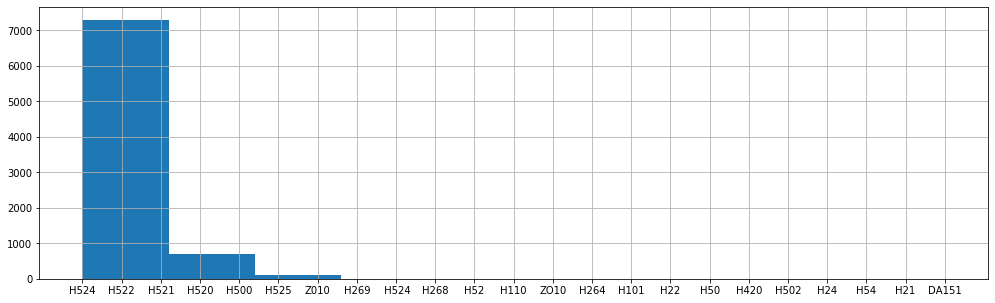

In [20]:
optometria_dep['diagnostico'] = optometria_dep['diagnostico'].str.upper()
optometria_dep['diagnostico'].hist(figsize = (17,5))

In [138]:
optometria_dep['diagnostico'].unique()

array(['H524', 'H522', 'H521', 'H520', 'H500', 'H525', 'Z010', 'H269',
       ' H524', 'H268', 'H52', 'H110', 'ZO10', 'H264', 'H101', 'H22', nan,
       'H50', 'H420', 'H502', 'H24', 'H54', 'H21', 'DA151'], dtype=object)

Se depuran los registros que no tienen diagnóstico, en caso de que existan

In [21]:
optometria_dep.drop(optometria_dep[optometria_dep['diagnostico'].isnull()].index, axis = 0, inplace = True)

In [40]:
optometria_dep.shape

(8113, 38)

Análisis de medidas visuales

* El valor de balance se refiere a cuando un ojo no recupera visión, el optometra le asigna una fórmula similar a la del otro ojo 
* N significa neutro y toma valor a cero
* Los valores impracticable y no aplica significan que el examen por alguna razón no se puedo prácticar, se eliminan los registros que tomen ese valor del todo el dataset

In [33]:
optometria_dep['esfera-od'].unique()

array([2, 'N', -1, 1.5, -0.25, 2.75, -1.25, 3.5, -0.5, 0.25, 1, 0.75,
       3.25, 0.5, 1.25, -1.5, -3, 2.5, 1.75, -2.75, 3, -0.75, -6, -2.5,
       -2, 2.25, -8.5, -3.5, 4, '-0.25', -7, nan, 4.5, -0.258, -7.5, 5.5,
       -4.5, 3.75, 5, -1.75, -4.25, -3.25, -7.25, -4, -11, -4.75, 4.25,
       -6.5, -2.25, 6, -8, -9, -5, 'NO APLICA ', -5.5, 6.5, -12, -14, 7,
       6.75, -6.75, 10, -11.5, 9, 2.501, -3.75, -6.25, 'BALANCE ', 0.501,
       '-15.00', -18, '-0.50', '-8.00', '-7.00', ' N', '-1.00', -8.75,
       -11.75, 'IMPRACTICABLE ', -8.25, 5.25, 8, 4.75, 'n', -5.75, 7.5,
       8.5, -19, -15, -1.74, -20, 6.25, 1.56], dtype=object)

In [22]:
optometria_dep['esfera-od'] = np.where((optometria_dep['esfera-od']  == 'N') | (optometria_dep['esfera-od']  == 'n') | (optometria_dep['esfera-od']  == ' N') | (optometria_dep['esfera-od']  == 'N ') | (optometria_dep['esfera-od']  == ' n') | (optometria_dep['esfera-od']  == 'n '), 0.0, optometria_dep['esfera-od'])
optometria_dep['esfera-od'] = np.where((optometria_dep['esfera-od']  == 'BALANCE') | (optometria_dep['esfera-od']  == 'BALANCE '), optometria_dep['esfera-oi'], optometria_dep['esfera-od']) 

In [23]:
optometria_dep.drop((optometria_dep[optometria_dep['esfera-od'] == 'IMPRACTICABLE'].index) | (optometria_dep[optometria_dep['esfera-od'] == 'IMPRACTICABLE '].index) | (optometria_dep[optometria_dep['esfera-od'] == 'NO APLICA '].index) | (optometria_dep[optometria_dep['esfera-od'] == 'NO APLICA '].index), axis = 0, inplace = True)

In [88]:
optometria_dep['cilindro-od'].unique()

array([-0.5, -0.75, -2.5, nan, -1, -0.25, -1.5, -3, -3.5, -4.5, -1.25, -2,
       -1.75, '-2.00', -2.25, -2.75, -3.25, -5, ' ', -5.5, '-1.25', -4,
       -4.75, -6, '-0.75', '-5.00', -7, -3.75, '-0.50', -0.258, '-7.00',
       '-1.00', '-1.50', '-2.50', -0.59, 'BALANCE', -3.2, 'BALANCE ',
       -1.2, -0.6, -2.752, -6.5, -0.754], dtype=object)

In [24]:
optometria_dep['cilindro-od'] = np.where((optometria_dep['cilindro-od']  == 'BALANCE') | (optometria_dep['cilindro-od']  == 'BALANCE '), optometria_dep['cilindro-oi'], optometria_dep['cilindro-od']) 
optometria_dep['cilindro-od'] = np.where((optometria_dep['cilindro-od'] == ' '), 0.0, optometria_dep['cilindro-od'])

In [29]:
optometria_dep['add-od'].unique()

array([nan, 2.75, 2, 2.25, 1.25, 1.75, 1.5, 2.5, 3, 1, -1, '   ', 2.275,
       ' ', 0.75, 3.5, -1.75, -2.5, 1.45, -1.5, 2.26], dtype=object)

In [25]:
#optometria_dep['add-od'] = optometria_dep['add-od'].str.strip()
optometria_dep['add-od'] = np.where((optometria_dep['add-od'] == '   ') | (optometria_dep['add-od'] == ' '), 0.0 ,optometria_dep['add-od'])

In [46]:
optometria_dep['esfera-oi'].unique()

array([2, -0.5, -1, 1.25, 0.0, -0.25, 2.75, -2.5, 0.25, 3.75, 1.5, 1, 0.5,
       0.75, -1.75, 2.5, -1.5, 2.25, -1.25, -0.75, 1.75, 3, -5.5, -2,
       -3.75, 4, -7, 4.5, -6, -7.5, 5, -4, -4.5, 3.5, 3.25, '-0.25', -10,
       5.5, -8, -4.25, -3, -6.5, -6.25, '-5.00', -3.25, -5, -2.25, 6.5,
       -3.5, -2.75, 6, -7.75, -9, -13, 6.75, -8.5, 11, -12, 7.5, 0.501,
       -5.75, 4.25, -4.75, -15.75, -18, 1.2, '-1.00', 7, 4.75, 0.72,
       -1.72, 10, 8, 5.25, 10.5, -14, -19, -15, -20, 8.5, 0.025, -1.74,
       5.75, -10.5], dtype=object)

In [26]:
optometria_dep['esfera-oi'] = np.where((optometria_dep['esfera-oi']  == 'N') | (optometria_dep['esfera-oi']  == ' N') | (optometria_dep['esfera-oi']  == 'N ') | (optometria_dep['esfera-oi']  == 'n') | (optometria_dep['esfera-oi']  == ' n') | (optometria_dep['esfera-oi']  == 'n '), 0.0, optometria_dep['esfera-oi'])

optometria_dep.drop((optometria_dep[optometria_dep['esfera-oi'] == 'NO APLICA '].index) | (optometria_dep[optometria_dep['esfera-oi'] == 'NO APLICA'].index), axis = 0, inplace = True)

In [94]:
optometria_dep['cilindro-oi'].unique() 

array([-0.25, nan, -2.5, -0.75, -0.5, -1.25, -1, -1.5, -4, -6.5, -2,
       -1.75, -2.75, -4.5, -2.25, '-2.00', 'N', -4.25, -3, -3.75, -3.5,
       -4.75, '-0.50', -5, 0.5, -5.75, 'BALANCE', -5.5, -0.5018, -0.50135,
       -7, -3.25, 0.75, 0.25, '-1.00', '-1.50', '-0.75', 'BALANCE ', 1.5,
       -8, -6, 2.25], dtype=object)

In [27]:
optometria_dep['cilindro-oi'] = np.where((optometria_dep['cilindro-oi']  == 'N'), 0.0, optometria_dep['cilindro-oi'])

optometria_dep['cilindro-oi'] = np.where((optometria_dep['cilindro-oi']  == 'BALANCE') | (optometria_dep['cilindro-oi']  == 'BALANCE '), optometria_dep['cilindro-od'], optometria_dep['cilindro-oi']) 

In [96]:
optometria_dep['eje-od'].unique()

array([100.  ,  70.  ,   5.  ,    nan,  90.  ,  40.  , 105.  ,  50.  ,
        30.  ,  80.  ,  10.  , 160.  ,  25.  ,  95.  , 170.  ,  20.  ,
         0.  ,  75.  ,  60.  ,  45.  ,  85.  ,  15.  , 135.  , 110.  ,
       175.  , 115.  , 120.  , 165.  ,  35.  , 130.  , 155.  , 125.  ,
       150.  , 140.  ,  55.  ,  65.  , 145.  ,   0.25, 180.  ,   2.  ,
         3.  ,  12.  ,  76.  , 168.  ,   2.25])

In [97]:
optometria_dep['eje-oi'].unique()

array([80, nan, 15, 50, 90, 5, 160, 10, 150, 170, 115, 140, 120, 60, 100,
       70, 0, 85, 45, 175, 65, 135, 75, 25, 20, 145, 95, 30, 40, 110, 165,
       155, 130, 162, 105, 2.5, 180, 'O', 55, 35, 91, 125, 164, 8, 66],
      dtype=object)

In [28]:
optometria_dep['eje-oi'] = np.where((optometria_dep['eje-oi'] == 'O'), 0.0, optometria_dep['add-oi'])
optometria_dep['eje-oi'] = np.where((optometria_dep['eje-oi'] == ' '), 0.0, optometria_dep['add-oi'])

In [99]:
optometria_dep['add-oi'].unique() 

array([nan, 2.75, 2, 2.25, 1.25, 1.75, 1.5, 2.5, 3, 1, ' ', -2.75, -2,
       2.225, 0.5, -1.5, 0.25, 1.745], dtype=object)

In [29]:
optometria_dep['add-oi'] = np.where((optometria_dep['add-oi'] == ' '), 0.0, optometria_dep['add-oi'])

In [219]:
optometria_dep['genero'].unique() 

array(['M', 'H'], dtype=object)

In [30]:
optometria_dep['genero'] = optometria_dep['genero'].str.strip() #Revisar nulos
dfDummiesgenero = pd.get_dummies(optometria_dep['genero'], prefix = 'genero')
optometria_dep = pd.concat([optometria_dep, dfDummiesgenero], axis=1)

In [51]:
optometria_dep['usa_gafas'].unique()

array(['Si', nan, 'No', 'SI', 'NO', 'si'], dtype=object)

In [31]:
optometria_dep['usa_gafas'] = optometria_dep['usa_gafas'].str.upper()
optometria_dep['usa_gafas'] = np.where(optometria_dep['usa_gafas'].isnull(), 'NO', optometria_dep['usa_gafas'])

In [32]:
#Codificar valores de si una gafas o no
dfDummiesUsaGafas = pd.get_dummies(optometria_dep['usa_gafas'], prefix = 'usa_gafas')
optometria_dep = pd.concat([optometria_dep, dfDummiesUsaGafas], axis=1)

In [33]:
#Se ajuste el nombre del glaucoma de la bd de inscritos, ya que corresponde a la pregunta: Alguien en su familia sufre de glaucoma?
optometria_dep.rename(columns = {'glaucoma':'glaucoma_flia'}, inplace = True)

In [34]:
optometria_dep['glaucoma_flia'].unique()  #Todo valor vacio significa que no tiene glaucoma

array(['No', 'Si', nan, 'NO', 'SI'], dtype=object)

In [35]:
optometria_dep['glaucoma_flia'] = optometria_dep['glaucoma_flia'].str.upper()
optometria_dep['glaucoma_flia'] = np.where(optometria_dep['glaucoma_flia'].isnull(), 0, optometria_dep['glaucoma_flia'])
optometria_dep['glaucoma_flia'] = np.where(optometria_dep['glaucoma_flia'] == 'SI', 1, 0)

In [166]:
optometria_dep['enfermedad'].unique() #Esta columna reune las enfermedades de Hipertension, Glaucoma, Diabetes

array(['H', nan, 'D', 'G', 'D-H', 'H-G', 'H-D', 'D-G', 'D ', 'H ',
       'D-H-G', 'G-H', 'D/H', 'H/G', 'D-G-H', 'D/G', 'H/D', 'D/H/G',
       'H/D/G', 'D-H ', 'N', 'H- G', 'D--H', 'G ', 'h'], dtype=object)

Derivación a partir de la columna enfermedad

In [36]:
optometria_dep['hipertension'] = optometria_dep['enfermedad'].map(lambda x: str(x).upper().find('H') != -1)
optometria_dep['diabetes'] = optometria_dep['enfermedad'].map(lambda x: str(x).upper().find('D') != -1)
optometria_dep['glaucoma'] = optometria_dep['enfermedad'].map(lambda x: str(x).upper().find('G') != -1)

In [58]:
optometria_dep['exam_ojos'].unique() #Si esta vacio es porque nunca se ha realizado un examen de ojos

array(['De 1 a 2 años', 'Mas de 2 años', 'Menos de 1 año', nan,
       'Menos de 1 año ', 'DE 1 A 2 AÑOS', 'MENOS DE 1 AÑO'], dtype=object)

In [37]:
optometria_dep['exam_ojos'] = optometria_dep['exam_ojos'].str.upper()
optometria_dep['exam_ojos'] = np.where(optometria_dep['exam_ojos'].isnull(), 'NUNCA', optometria_dep['exam_ojos'])

In [38]:
#Codificar valores de examen de los ojos
dfDummiesExam = pd.get_dummies(optometria_dep['exam_ojos'], prefix = 'exam_ojos')
optometria_dep = pd.concat([optometria_dep, dfDummiesExam], axis=1)

In [229]:
optometria_dep['tiem_gafas'].unique()

array(['Mas de 2 años', nan, 'Menos de 1 año', 'De 1 a 2 años',
       'DE 1 A 2 AÑOS', 'Mas de  2 años'], dtype=object)

In [39]:
optometria_dep['tiem_gafas'] = optometria_dep['tiem_gafas'].str.upper()
optometria_dep['tiem_gafas'] = np.where(optometria_dep['tiem_gafas'].isnull(), 'NO', optometria_dep['tiem_gafas'])

In [40]:
#Codificar valores de examen de los ojos
dfDummiesGafas = pd.get_dummies(optometria_dep['tiem_gafas'], prefix = 'tiem_gafas')
optometria_dep = pd.concat([optometria_dep, dfDummiesGafas], axis=1)

Luego de realizar el análisis de cada una de las características y realizar ajustes de acuerdo a las definiones del negocios, se revisa el estado de los valores faltantes en el dataset

In [41]:
optometria_dep.isna().sum()

edad                                                              0
consulta                                                          0
estuche y paño                                                    0
montura                                                           0
diagnostico                                                       0
esfera-od                                                         0
cilindro-od                                                       0
eje-od                                                            0
add-od                                                            0
esfera-oi                                                         0
cilindro-oi                                                       0
eje-oi                                                            0
add-oi                                                            0
genero                                                            0
exam_ojos                                       

In [ ]:
#Para la caracteristica enfermedad siguen existiendo valores nulos, esta característica fue abierta en los posibles valores que ella toma, por lo cual estos valores nulos no son de interés.

Análisis de la distribución de los pacientes de acuerdo a la información rescatada del verbatim de descripción. Siendo:

* 0. Nunca ha tenido el síntoma
* 1. Ha tenido el síntoma

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x169F3F50>,
      dtype=object)

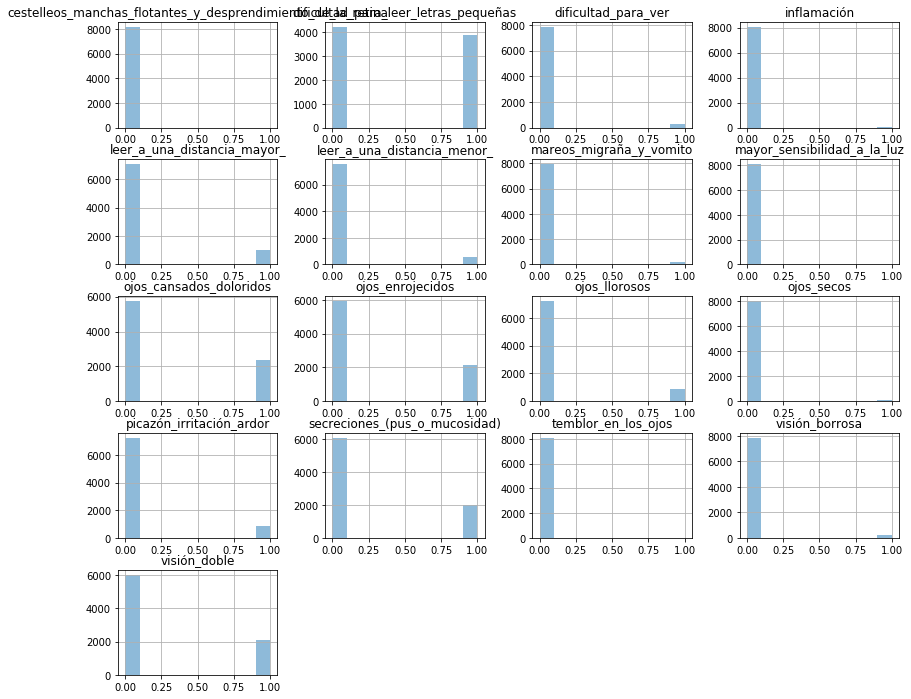

In [64]:
optometria_dep[['picazón_irritación_ardor', 'ojos_cansados_doloridos', 'ojos_llorosos', 'ojos_secos', 'visión_borrosa', 'visión_doble',  'mayor_sensibilidad_a_la_luz', 'dificultad_para_ver', 'dificultad_para_leer_letras_pequeñas', 'leer_a_una_distancia_mayor_', 'secreciones_(pus_o_mucosidad)', 'leer_a_una_distancia_menor_', 'ojos_enrojecidos', 'mareos_migraña_y_vomito', 'inflamación', 'temblor_en_los_ojos',        'cestelleos_manchas_flotantes_y_desprendimiento_de_la_retina']].hist(alpha = 0.5, figsize = (14,12))

REDUCCION DE CARACTERISTICAS 

Una vez se ha revisado la información contenida en cada una de las columnas del dataframe y aplicado limpieza sobre ellas, se procede a realizar análisis de las dimensiones

De la limpieza de datos se concluye:

- La variable Enfermedad se abre en tres variables:

  * Hipertensión
  * Glaucoma
  * Diabetes

- Todos los valores 'na' de las mediciones no pueden ser interpretados como valores cero

- Dado que el campo consulta indica si recibio consulta o no y para los datos del dataframe no hay varibilidad mostrada con una desviación estandar igual a cero, esta columna puede ser eliminada

- Las columnas de montura y estuche y paño juntas significa que una persona luego de ser atendido por el optómetra le fueron recetados lentes, esta información se consolida en requiere_gafas

- Las caracteristicas genero, usa_gafas, exam_ojos, tiem_gafas, pueden ser eliminadas ya que fueron numerizadas.

In [42]:
optometria_dep.drop(['enfermedad','consulta','montura', 'estuche y paño', 'genero', 'usa_gafas', 'exam_ojos', 'tiem_gafas'], axis = 1, inplace = True)

Construcción de la variable objetivo

Pacientes con diagnóstio principal Astigmatismo (H522 de acuerdo al CIE-10)

In [43]:
optometria_dep['astigmatismo'] = np.where(optometria_dep['diagnostico'] == 'H522',1,0) #1 Tiene astigmatismo, 0 No
#H522 astigmatismo
#H521 miopia
#H524 presbicia 

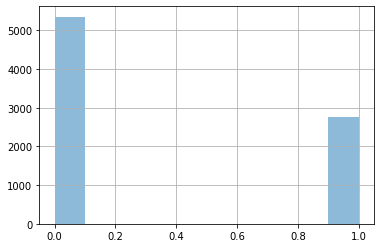

In [67]:
#Distribución de las clases
optometria_dep['astigmatismo'].hist(alpha = 0.5)

Las clases estan desbalanceadas, es importante al aplicar un modelo de machine learning balancear las clases

In [44]:
#Se elimina la caracteríticas diagnostico ya que redunda con la variable objetivo
optometria_dep.drop(['diagnostico'], axis = 1, inplace = True)

Dado que varias de las variables de medición óptica esan de tipo object y para efectos del balanceo deben ser númericas, se hace la conversión

In [45]:
optometria_dep['esfera-od'] = optometria_dep['esfera-od'].astype(float)
optometria_dep['cilindro-od'] = optometria_dep['cilindro-od'].astype(float)
optometria_dep['eje-od'] = optometria_dep['cilindro-od'].astype(float)
optometria_dep['add-od'] = optometria_dep['add-od'].astype(float)
optometria_dep['esfera-oi'] = optometria_dep['esfera-oi'].astype(float)
optometria_dep['cilindro-oi'] = optometria_dep['cilindro-oi'].astype(float)
optometria_dep['eje-oi'] = optometria_dep['eje-oi'].astype(float)
optometria_dep['add-oi'] = optometria_dep['add-oi'].astype(float)

Existen tipos de lentes de acuerdo a las medidas tomadas en la revisión:
- Esfericos Monofocal. Tienen valores en las esferas (EM)
- Esferocilindricos Monofocal. Tiene esfera, cilindro y eje (ECM)
- Esfericos Bifocal. Tiene esfera y adición (EB)
- Esferocilindricos Bifocal. Tienen esfera, cilindro, eje y adición (ECB)

In [140]:
#optometria_dep['lente_EM_oi'] = np.where((optometria_dep['esfera-oi'].notna()) & (np.isnan(optometria_dep['cilindro-oi'])) & (np.isnan(optometria_dep['eje-oi'])) & (np.isnan(optometria_dep['add-oi'])),1,0)

#optometria_dep['lente_ECM_oi'] = np.where((optometria_dep['esfera-oi'].notna()) & (optometria_dep['cilindro-oi'].notna()) & (optometria_dep['eje-oi'].notna()) & (np.isnan(optometria_dep['add-oi'])),1,0)

#optometria_dep['lente_EB_oi'] = np.where((optometria_dep['esfera-oi'].notna()) & (np.isnan(optometria_dep['cilindro-oi'])) & (np.isnan(optometria_dep['eje-oi'])) & (optometria_dep['add-oi'].notna()),1,0)

#optometria_dep['lente_ECB_oi'] = np.where((optometria_dep['esfera-oi'].notna()) & (optometria_dep['cilindro-oi'].notna()) & (optometria_dep['eje-oi'].notna()) & (optometria_dep['add-oi'].notna()),1,0)

In [141]:
#optometria_dep['lente_EM_od'] = np.where((optometria_dep['esfera-od'].notna()) & (np.isnan(optometria_dep['cilindro-od'])) & (np.isnan(optometria_dep['eje-od'])) & (np.isnan(optometria_dep['add-od'])),1,0)

#optometria_dep['lente_ECM_od'] = np.where((optometria_dep['esfera-od'].notna()) & (optometria_dep['cilindro-od'].notna()) & (optometria_dep['eje-od'].notna()) & (np.isnan(optometria_dep['add-od'])),1,0)

#optometria_dep['lente_EB_od'] = np.where((optometria_dep['esfera-od'].notna()) & (np.isnan(optometria_dep['cilindro-od'])) & (np.isnan(optometria_dep['eje-od'])) & (optometria_dep['add-od'].notna()),1,0)

#optometria_dep['lente_ECB_od'] = np.where((optometria_dep['esfera-od'].notna()) & (optometria_dep['cilindro-od'].notna()) & (optometria_dep['eje-od'].notna()) & (optometria_dep['add-od'].notna()),1,0)

Análisis descriptivo de las variables una vez realizado la seleccón de caracteristicas

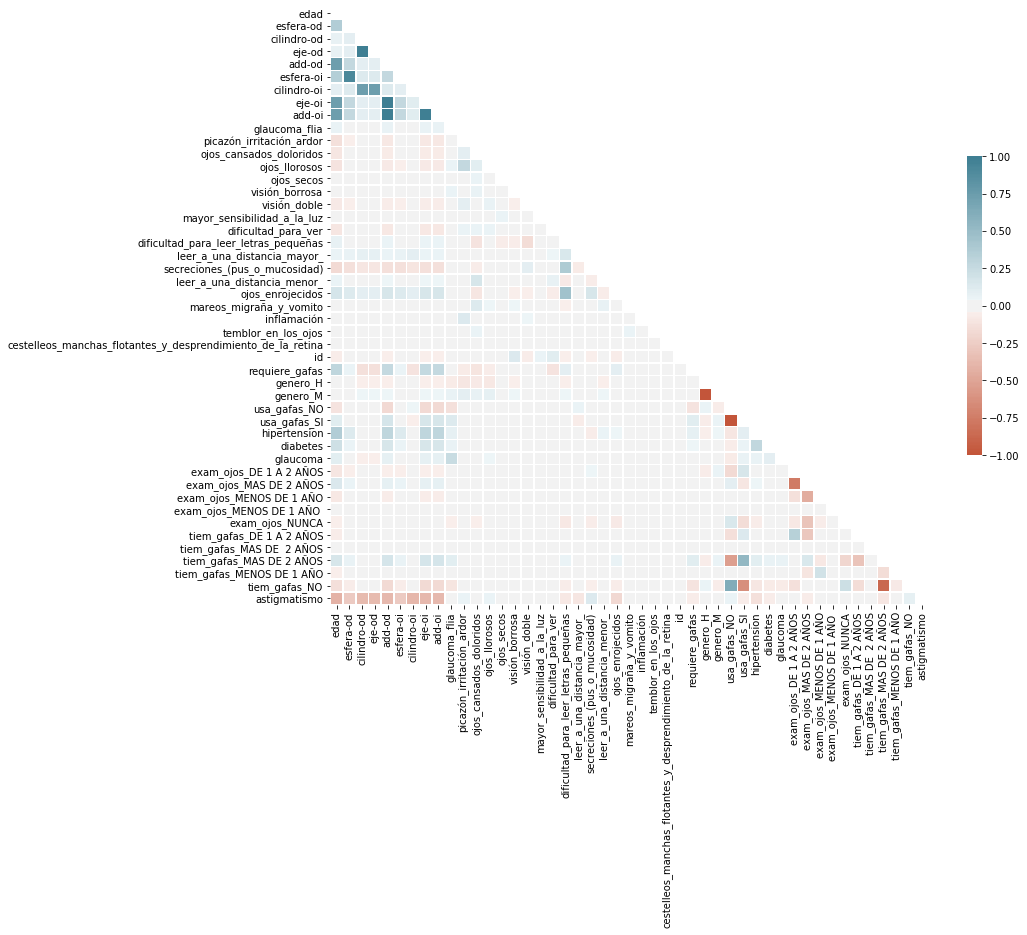

In [46]:
matriz_corr = optometria_dep.corr()
mask = np.triu(np.ones_like(matriz_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(14, 11))
cmap = sn.diverging_palette(20, 220, n = 200)
sn.heatmap(matriz_corr, mask = mask, cmap=cmap, vmin = -1, vmax = 1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

**Conclusiones matriz de correlación**

Correlaciones positivas
- edad y add-oi
- edad y add-od
- edad y eje-oi
- esfera-oi y esfera-od
- eje-od y cilindro-od
- add-od y eje-oi
- add-od y add-oi
- add-oi y eje-oi
- lente_EBC_od y lente_EBC_oi


Correlaciones negativas
- tiem_gafas_MAS DE 2 AÑOS y tiem_gafas_NO
- genero_H y genero_M
- usa_gafas_NO y usa_gafas_SI

Análisis grafico 

In [ ]:
sn.pairplot(optometria_dep[['edad', 'esfera-od', 'cilindro-od', 'eje-od', 'add-od', 'esfera-oi',
       'cilindro-oi', 'eje-oi', 'add-oi', 'glaucoma_flia', 'astigmatismo']], hue = 'astigmatismo')

In [ ]:
#El glaucoma familiar no describe el astigmatismo, al igual que las esferas, por lo tanto se pueden eliminar del dataset

In [ ]:
sn.pairplot(optometria_dep[['picazón_irritación_ardor', 'ojos_cansados_doloridos', 'ojos_llorosos',
       'ojos_secos', 'visión_borrosa', 'visión_doble', 'mayor_sensibilidad_a_la_luz', 'dificultad_para_ver',
       'dificultad_para_leer_letras_pequeñas', 'leer_a_una_distancia_mayor_', 'astigmatismo']], hue = 
       'astigmatismo')

In [ ]:
sn.pairplot(optometria_dep[['secreciones_(pus_o_mucosidad)', 
       'leer_a_una_distancia_menor_', 'ojos_enrojecidos', 'mareos_migraña_y_vomito', 'inflamación',
       'temblor_en_los_ojos', 'cestelleos_manchas_flotantes_y_desprendimiento_de_la_retina', 'astigmatismo']], hue = 
       'astigmatismo')

Las sintomatologías anteriores no describe el astigmatimo, por lo cual se pueden eliminar del dataset

In [ ]:
sn.pairplot(optometria_dep[['requiere_gafas', 'genero_H', 'genero_M', 'usa_gafas_NO',
       'usa_gafas_SI', 'hipertension', 'diabetes', 'glaucoma',
       'exam_ojos_DE 1 A 2 AÑOS', 'exam_ojos_MAS DE 2 AÑOS','astigmatismo']], hue = 
       'astigmatismo')

In [ ]:
sn.pairplot(optometria_dep[['exam_ojos_MENOS DE 1 AÑO', 'exam_ojos_MENOS DE 1 AÑO ',
       'exam_ojos_NUNCA', 'tiem_gafas_DE 1 A 2 AÑOS',
       'tiem_gafas_MAS DE  2 AÑOS', 'tiem_gafas_MAS DE 2 AÑOS',
       'tiem_gafas_MENOS DE 1 AÑO', 'tiem_gafas_NO', 'astigmatismo']], hue = 
       'astigmatismo')

In [ ]:
De las caracteristicas anteriores es relevante tiem_gafas_MAS DE 2 AÑOS, exam_ojos_MENOS DE 1 AÑO, por lo tanto se dejan como parte del dataset

In [48]:
columnas = ['edad', 'cilindro-od', 'eje-od', 'add-od', 'cilindro-oi', 'eje-oi', 'add-oi', 'tiem_gafas_MAS DE 2 AÑOS', 'exam_ojos_MENOS DE 1 AÑO ', 'astigmatismo']

In [49]:
optometria = optometria_dep[columnas]

[Text(0.5, 0, 'edad'),
 Text(1.5, 0, 'cilindro-od'),
 Text(2.5, 0, 'eje-od'),
 Text(3.5, 0, 'add-od'),
 Text(4.5, 0, 'cilindro-oi'),
 Text(5.5, 0, 'eje-oi'),
 Text(6.5, 0, 'add-oi'),
 Text(7.5, 0, 'tiem_gafas_MAS DE 2 AÑOS'),
 Text(8.5, 0, 'exam_ojos_MENOS DE 1 AÑO '),
 Text(9.5, 0, 'astigmatismo')]

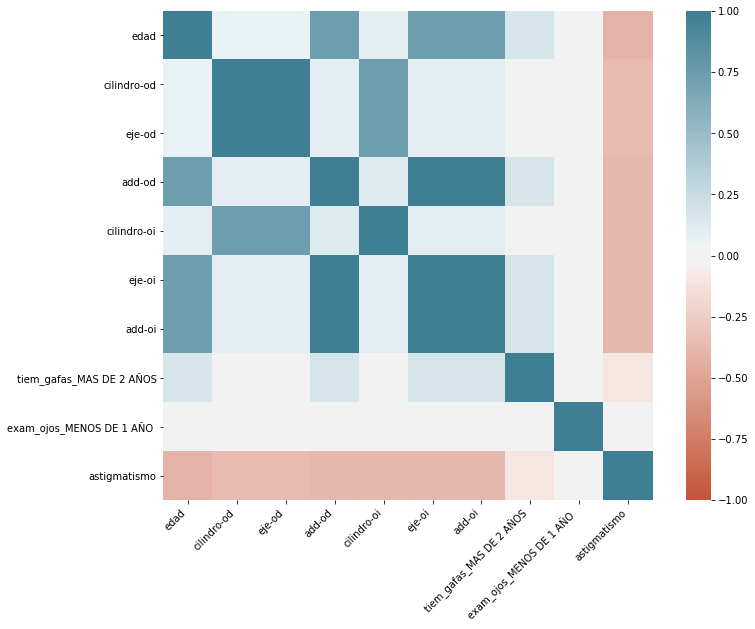

In [50]:
matriz_corr_new = optometria.corr()
plt.figure(figsize=(12, 9))
ax = sn.heatmap(matriz_corr_new, vmin = -1, vmax = 1, center = 0, cmap = sn.diverging_palette(20, 220, n = 200), square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')

Luego de seleccionar solo las caracteristicas ......

Extraccón de caracteristicas usando:

- Árbol de decisión
- Bosque aleatorio
- PCA

División de datos de entrenamiento y prueba

In [51]:
modelos_vbles = optometria.drop('astigmatismo', axis = 1)
X = modelos_vbles
y = optometria.astigmatismo
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)

Balanceo de Clases

In [52]:
sm = SMOTE(random_state = 0)
x_est, y_est = sm.fit_sample(x_train, y_train)

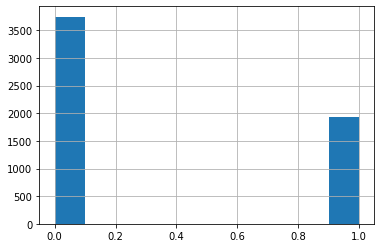

In [80]:
#Antes de balancear
y_train.hist()

6439    0
1362    1
2769    0
925     1
3049    0
       ..
259     0
1901    0
5047    1
999     1
3390    0
Name: astigmatismo, Length: 5677, dtype: int32

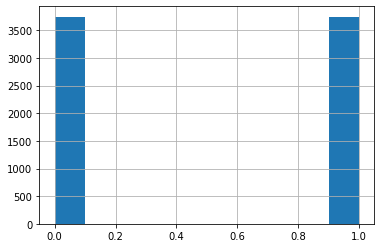

In [78]:
#Después de balancear
y_est.hist()

Árbol de decisiones

Las variable que tiene aportan a los datos más importancia son edad, cilindro-od, eje-od, cilindro-oi. Por su lado exam_ojos_MENOS DE 1 AÑO no tiene ningún peso.

In [53]:
arbol = DecisionTreeClassifier(criterion= 'entropy',random_state=0)
arbol.fit(x_est, y_est)
y_pred = arbol.predict(x_test)

In [54]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8388820386354295


Del árbol de decisión, las variable que tiene aportan a los datos más importancia son edad, cilindro-od, eje-od, cilindro-oi. Por su lado exam_ojos_MENOS DE 1 AÑO no tiene ningún peso.

In [55]:
mask = arbol.feature_importances_ > 0.05
reduced_X = X.loc[:,mask]
print(reduced_X.columns)

Index(['edad', 'cilindro-od', 'eje-od', 'cilindro-oi'], dtype='object')


In [56]:
print(dict(zip(X.columns, arbol.feature_importances_.round(2))))

{'edad': 0.31, 'cilindro-od': 0.1, 'eje-od': 0.06, 'add-od': 0.03, 'cilindro-oi': 0.42, 'eje-oi': 0.02, 'add-oi': 0.03, 'tiem_gafas_MAS DE 2 AÑOS': 0.03, 'exam_ojos_MENOS DE 1 AÑO ': 0.0}


Bosque Aleatorio

Para bosques aleatorios, las variables con mayor importancia son edad, cilindro-od, eje-od, cilindro-oi. Aquí tanto tiem_gafas_MAS DE 2 AÑOS y exam_ojos_MENOS DE 1 AÑO  no tienen relevancia.

In [57]:
rf = RandomForestClassifier(random_state=0)
rf.fit(x_est, y_est)
mask_rf = rf.feature_importances_.round(2) > 0.05
print(dict(zip(X.columns, mask_rf)))

{'edad': True, 'cilindro-od': True, 'eje-od': True, 'add-od': False, 'cilindro-oi': True, 'eje-oi': False, 'add-oi': False, 'tiem_gafas_MAS DE 2 AÑOS': False, 'exam_ojos_MENOS DE 1 AÑO ': False}


PCA

In [58]:
#Escalar los datos
x = StandardScaler().fit_transform(X)

Se revisa que la normalización de los datos tengan media cero y desviación estandar de uno

In [59]:
print('Media: ', np.mean(x))
print('Desviación estándar: ', np.std(x))

Media:  -1.1097667060782494e-17
Desviación estándar:  1.0


In [60]:
pca_opt = PCA(n_components=2)
principalComponents = pca_opt.fit_transform(x)

In [61]:
optometria_PCA = pd.DataFrame(data = principalComponents, columns = ['PCA1', 'PCA2'])

In [62]:
optometria_PCA.head(2)

,PCA1,PCA2
0,1.540353,-0.809010
1,2.483970,-0.886359


In [63]:
explained_variance = np.var(principalComponents, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
#print('Varianza: ', explained_variance)
print('Ratio de varianza ',explained_variance_ratio)

Ratio de varianza  [0.59409296 0.40590704]


El componente 1 explica el 59% de la información mientras que el componente 2 contiene 40% de la información. Proyectar la data a dos dimensiones se pierde casi el 1% de información.

Conocer el número de compoenentes óptimos

In [65]:
print(pd.DataFrame(pca_opt.components_, columns = X.columns, index = ['PCA1','PCA2']))

edad  cilindro-od    eje-od    add-od  cilindro-oi    eje-oi  \
PCA1 -0.420927    -0.163915 -0.163915 -0.492394    -0.163517 -0.493182   
PCA2  0.124930    -0.574398 -0.574398  0.139814    -0.506615  0.140899   

        add-oi  tiem_gafas_MAS DE 2 AÑOS  exam_ojos_MENOS DE 1 AÑO   
PCA1 -0.493182                 -0.115596                   0.008643  
PCA2  0.140899                  0.092814                  -0.000950  


Por árboles de decisión, random forest y PCA se eliminan las variables exam_ojos_MENOS DE 1 AÑO y tiem_gafas_MAS DE 2 AÑOS, ya que su factor de importancia tiende a cero 

In [66]:
columnas = ['edad', 'cilindro-od', 'eje-od', 'add-od', 'cilindro-oi', 'eje-oi', 'add-oi', 'astigmatismo']
optometria = optometria[columnas]

Ejecución del modelo de clasificación con las caracteristicas seleccionadas luego de realizar la selección de caracteristicas por medio de análisis descriptivo y ejecución de modelos de ML

In [67]:
# Se vuelve a calcular los datos de entrenamiento y prueba para efectos de los modelos de clasificación con las variables seleccionadas

modelos_vbles = optometria.drop('astigmatismo', axis = 1)
X_ast = modelos_vbles
y_ast = optometria.astigmatismo
x_train_ast, x_test_ast, y_train_ast, y_test_ast = train_test_split(X_ast, y_ast, test_size = 0.3, random_state = 1, stratify = y)

In [68]:
# Se balancean nuevamente las clases con los datos recién particionado

sm_ast = SMOTE(random_state = 0)
x_est_ast, y_est_ast = sm_ast.fit_sample(x_train_ast, y_train_ast)

Árbol de decisiones con cross validation 

In [145]:
random.seed(1988)
from sklearn.model_selection import cross_val_predict
arbol_ast = DecisionTreeClassifier(criterion = 'entropy',random_state=0)
arbol_ast.fit(x_est_ast, y_est_ast)

#Se toma k = 10 como valor común en el campo de acción de ML
cv_scores = cross_val_score(arbol_ast_fit, X_ast, y_ast, cv=10, scoring='f1')
print("Recall: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

Recall: 0.74 (+/- 0.09)


Por árboles de decisión con cross validation tomando 10 divisiones de la data y como medida de validación el f1-score para equilibar la precision y el recall, tenemos que el modelo es efectivo en un 74%.

Regresión lógistica

In [101]:
random.seed(1988)
logreg = LogisticRegression()
logreg.fit(x_est_ast, y_est_ast)
y_pred_log = logreg.predict(x_test_ast)

Text(33.0, 0.5, 'Real')

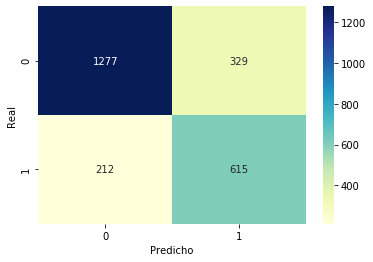

In [126]:
rlog_cm = confusion_matrix(y_test_ast, y_pred_log)
sn.heatmap(rlog_cm, fmt='', annot = True, cmap = 'YlGnBu')
plt.xlabel('Predicho')
plt.ylabel('Real')

In [127]:
print(classification_report(y_test_ast, y_pred_log))

precision    recall  f1-score   support

           0       0.86      0.80      0.83      1606
           1       0.65      0.74      0.69       827

    accuracy                           0.78      2433
   macro avg       0.75      0.77      0.76      2433
weighted avg       0.79      0.78      0.78      2433



Por regresión lógistica, a partir de la matriz de confusión tenemos:

De 1606 pacientes cuyo diagnóstico principal no era astigmatismo, el modelo dijo que efectivamente no tenian astigmatismo 1277, equivale a un 70%, se equivoco en 329 pacientes a los cuales les dijo que si tenían astigmatismo, lo cual equivale a un 20%
Para los pacientes con astigmatismo, en total se tenían 827 personas, el modelo predice que de esos 827 pacientes, 212 no tiene astigmatismo (25%) y 615 si lo tenían (74%).

Si bien las métricas con este modelo sin utilizar cross validation (por efectos del ejercicio académico) son bajas, se concluye:
* En un 78% el modelo predice bien las clases astigmatismo y no astigmatismo (accuracy). 
* En un 74% el modelo clasificó correctamente la clase de astigmatismo para todos los valores que realmente eran astigmatismo (recall). Esto significa que 212 pacientes se quedaron sin recibir un diagnóstico correcto de un total de 827 personas.
* De los valores que el modelo catalogó como astigmatismo, un 65% de ellos realmente eran astigmatismo (precision). En este caso, se diagnóstico como astigmatismo en su diagnóstico principal a 329 pacientes, lo cual no es correcto.




Redes Neuronales